In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
dataset = MNIST(root='data/', download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 722kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.68MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]


In [3]:
len(dataset)

60000

In [4]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

label: 5


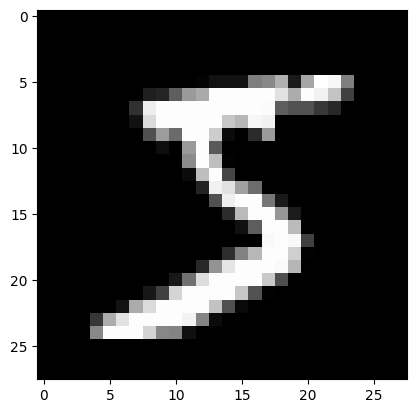

In [6]:
image, label = dataset[0]
plt.imshow(image , cmap='gray')
print('label:', label)

In [7]:
import torchvision.transforms as transforms

In [8]:
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [9]:
img_tensor, label = dataset[0]
print(img_tensor.shape)
print(label)

torch.Size([1, 28, 28])
5


In [10]:
print(img_tensor[:,10:15,10:15])
print(torch.max(img_tensor),torch.min(img_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


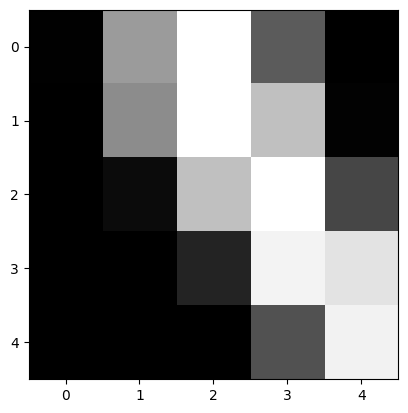

In [11]:
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

In [12]:
from torch.utils.data import random_split

train_ds,val_ds = random_split(dataset,[50000,10000])
len(train_ds),len(val_ds)

(50000, 10000)